# HoLCUs and QAOA

Author: Alejandro Mata Ali (ITCL)

In this notebook we implement the HoLCUs QAOA algorithm to solve QUBO problems. It runs over classical simulators in Aersimulator. It is designed to run in Google Colab.

We compare the execution time for the simple QAOA and the HoLCUs QAOA, without taking advantage of the repetition optimization for the HoLCUs.

## Packages

The libraries we will use will be mainly Qiskit, to make the quantum circuits, qiskit-aer-gpu to be able to use a GPU, matplotlib and pylatexenc to graph the quantum circuits, numpy and math for the basics of calculation and scipy for the optimizer.

For qiskit we will use version 1.3.2

In [36]:
%%capture
!pip install qiskit==1.3.2
!pip install matplotlib
!pip install pylatexenc
!pip install qiskit-aer-gpu

In [37]:
import numpy as np
import math
import matplotlib.pyplot as plt

#Tools from Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import StatePreparation, ZGate
from qiskit.visualization import plot_histogram

# Optimizer
from scipy.optimize import minimize

# Time
from time import perf_counter

---
# Cost functions

Let's start by defining a series of functions to calculate the cost of a combination and go from QUBO to Ising and vice versa.

## Cost function calculator

Given a cost matrix Q and an input vector x, compute the cost of the vector using

$C(\vec{x})=\vec{x}^T Q \vec{x}$.

Here we work with the QUBO matrix.

Input:
- x: binary vector.
- Q: cost matrix.

Return:
- Cost of the combination.

In [38]:
def cost_function(x:np.array, Q:np.array) -> float: #string, matrix -> value
    '''Calculates the cost of a solution.
    Input:
    - x: binary vector.
    - Q: cost matrix.

    Return:
    - Cost of the combination.'''
    cost = 0

    if type(x[0]) == str: x = np.array([ int(i) for i in x ])

    for i, _x1 in enumerate(x):#Left
        for j, _x2 in enumerate(x[i:]):#Right (no repetition)
            if _x1 == 1 and _x2 == 1:
                cost += Q[i,i+j]
    return coste

## QUBO to Ising Mapper

This function will be in charge of mapping the QUBO problem to an Ising problem. It receives the QUBO matrix and returns the corresponding Ising.

In [39]:
def Qubo_To_Ising(Q_qubo:np.array)-> np.array:
    '''This function maps the QUBO matrix to Ising matrix.
        H=Sum_[i](a_ii*x_i)+Sum_[i<j][a_ij*x_i*x_j] -> H=Sum_[i](b_ii*Z_i)+Sum_[i<j][b_ij*Z_i*Z_j]
        As x\in{0,1} y Z\in{1,-1}, x=(I-Z)/2. For the linear terms we ignore the additive constant and the following remains xi -> -Zi/2
        Then, b_ii+=(-1/2)a_ii

        The quadratics are (I_i-Z_i)/2*(I_j-Z_j)/2= (I_i*I_j-Z_i-Z_j+Z_i*Z_j)/4, then x_i*x_j -> (-Z_i-Z_j+Z_i*Z_j)/4
        Then, b_ii+=(-1/4)a_ij, b_jj+=(-1/4)a_ij and b_ij+=(+1/4)a_ij

        Input:
        - Q_qubo: QUBO matrix.
        Returns:
        - Ising matrix.'''

    d = Q_qubo.shape[0]
    Q_ising = np.zeros((d,d), dtype=float)

    for i in range(d):
        Q_ising[i][i] -= Q_qubo[i][i]/2       #b_ii+=(-1/2)a_ii
        for j in range(i+1,d):
            Q_ising[i][i] -=  Q_qubo[i][j]/4  #b_ii+=(-1/4)a_ij
            Q_ising[j][j] -=  Q_qubo[i][j]/4  #b_jj+=(-1/4)a_ij
            Q_ising[i][j] += +Q_qubo[i][j]/4  #b_ij+=(+1/4)a_ij

    for i in range(d):# Make the simmetrization
        for j in range(i+1,d):
            Q_ising[j][i]  =  Q_ising[i][j]

    return Q_ising

## Ising to Z Strings

This function passes the Ising matrix a list system. I do this so that the QAOA can read it more easily and generalize to other gates more easily.


In [40]:
def Q_matrix_To_Ising_List(Q_ising:np.array)-> np.array:
    '''We pass the Ising matrix to list.
    Input:
    - Q_ising: cost matrix.

    Returns:
    - List of Ising elements of the problem. Its elements are:
        [list_of_Z_gate_positions, coefficient] For each Pauli string.'''

    d = Q_ising.shape[0]
    list_ising = []
    for i in range(d):
        qubits = [i]# The diagonal term is just a Z
        coef = Q_ising[i][i]# We obtain the coefficient that multiplies the string
        if coef != 0: list_ising.append([qubits, coef])

        for j in range(i+1,d):# To choose the upper triangleTo choose the upper triangle
            qubits = [i,j]# Double Z
            coef = Q_ising[i][j]
            if coef != 0: list_ising.append([qubits, coef])

    return list_ising

And some functions to go from list to dictionary and vice versa.

In [41]:
def Z_Ising_to_Dict(Z_Ising: list) -> dict:
    '''Function that creates a dictionary from Ising lists.
    Args:
    - Z_Ising: list with the Z elements and positions.

    Retuns:
    - Dictionary.'''

    dicto = {}
    for term in Z_Ising:
        qubits = str(term[0])# Positions as str
        coef = term[1]
        dicto[qubits] = coef

    return dicto

def Z_Ising_to_List(Z_Ising_dict: dict) -> list:
    '''Function that creates lists from the Ising dictionary.
    Args:
    - Z_Ising: dictionary with the elements and positions of the Z's.

    Retuns:
    - List.'''

    l = []
    for key in Z_Ising_dict:
        qubits = [ int(character) for character in key if character.isnumeric() ]# For each character of the string
        coef = Z_Ising_dict[key]
        l.append([qubits, coef])
    return l

---
# QAOA Circuit

Let's make the functions that create the QAOA circuits we need.

## Main circuit

Function that creates the QAOA parametric circuit with the extra qubit for the Hadamard Test.

In [42]:
def QAOA_circuit(n_qubits:int, Z_Ising:list, n_layers:int) -> QuantumCircuit:
    '''Function that creates the QAOA circuit with the extra qubit for the Hadamard Test.
    Input:
    - n_qubits: number of qubits for the circuit.
    - Z_Ising: list of Ising Strings.
    - n_layers: number of layers of the QAOA.

    Returns:
    - QAOA circuit with the Hadamard Test ring.'''
    #Parameters
    angles = ParameterVector(f'angles', 2*n_layers)# One for beta and one for gamma

    #--------------------------------------------------------------------------
    qh = QuantumRegister( 1, 'H' )#Ancilla for Hadamard
    qr = QuantumRegister(n_qubits, 'q')
    cr = ClassicalRegister(1, 'c_H' )
    qc = QuantumCircuit(qh, qr, cr, name='Ising')

    qc.h(qh)
    qc.h(qr)

    for l in range(n_layers):
        for elem in Z_Ising:
            if len(elem[0]) == 1:# Z
                qc.rz(angles[n_layers+l]*elem[1], 1+elem[0][0])

        for elem in Z_Ising:# ZZ
            if len(elem[0]) == 2:
                qc.rzz(angles[n_layers+l]*elem[1], 1+elem[0][0], 1+elem[0][1])

        for i in range(n_qubits):# Mixer
            qc.rx(2*angles[l], 1+i, label=None)

    #Pretranspilamos esta parte ya
    qa = transpile(qc, AerSimulator(), optimization_level=2)

    return qa

## Function adding the Hadamard Test to the circuit

This function adds the Hadamard Test of an operator according to a list of Z positions.

Input:
- qc: circuit of the QAOA with the H qubit initialized.
- positions: positions of the Z gates.
Returns:
- Parameterized total circuit.

In [43]:
def H_evaluator(qc:QuantumCircuit, positions:list) -> QuantumCircuit:
    '''Function that generates the Hadamard Test part for a z operator.
    Input:
    - qc: circuit of the QAOA with the H qubit initialized.
    - positions: positions of the Z gates.
    Returns:
    - Parameterized total circuit.'''

    for i in positions:
        qc.cz(0, 1+i)

    qc.h(0)
    qc.measure(0, 0)

    qa = transpile(qc, AerSimulator(), optimization_level=2)

    return qa

## Circuit generator function

Function that generates all necessary QAOA circuits.

Input:
- Z_Ising: list of Ising terms.
- n_qubits: number of QAOA qubits.
- n_layers: number of layers in the QAOA.

Return:
- Parameterized quantum circuit.

In [44]:
def Ising_QAOA_Circuits(Z_Ising:list, n_qubits:int, n_layers:int):
    '''Function that generates the parametric QAOA circuits with each Z string and the H-Test.
    Input:
    - Z_Ising: list of Ising terms.
    - n_qubits: number of QAOA qubits.
    - n_layers: number of layers in the QAOA.

    Return:
    - Parameterized quantum circuit.'''
    # Base circuit
    qc = QAOA_circuit(n_qubits, Z_Ising, n_layers)

    # One circuit for each string
    qc_H = []
    for _s, string in enumerate(Z_Ising):
        qc_H.append(H_evaluator(qc.copy(), string[0]))

    return qc_H


---
# Execution and processing of results

Functions that execute the circuit and process results.

## Evaluator

This will be a function to measure the qubits needed given a given Zstring and process the result.

Input:
- angles: angles for the QAOA.
- qc: Parametric quantum circuit with the H-Test already added (that's why it doesn't need the string).
- normalization: coefficient with which this string goes.
- shots: number of shots.
- sim: backend.

returns:
- Expected value for that string.

In [45]:
def evaluator_string(angles:np.array, qc:QuantumCircuit, normalization:float,
              shots:int, sim) -> float:
    '''Function that executes the QAOA with H-Test and returns the expected value of that string.
    Input:
    - angles: angles for the QAOA.
    - qc: Parametric quantum circuit with the H-Test already added (that's why it doesn't need the string).
    - normalization: coefficient with which this string goes.
    - shots: number of shots.
    - sim: backend.

    returns:
    - Expected value for that string.'''

    qa = qc.assign_parameters(angles, inplace=False)

    counts_dict = sim.run(qa, shots=shots).result().get_counts()

    expected = (2*(counts_dict['0'] / shots) - 1 ) * normalization

    return expected


## Global evaluator

This function executes each particular string evaluator and collects all the results.

In [46]:
def evaluator(angles:np.array, qc_H:list, Z_Ising:list,
              shots:int, sim) -> float:
    '''Function that runs the QAOA with H-Test and returns the expected value for each string and sums them.
    Input:
    - angles: angles for the QAOA.
    - qc_H: list of parametric quantum circuits with the H-Test already added (that's why it doesn't need the string).
    - Z_Ising: list of Ising elements.
    - shots: number of shots.
    - sim: backend.

    Returns:
    - Expected value for the set of strings.'''

    expected_total = 0

    for _, coef in enumerate(Z_Ising):
        expected_total += evaluator_string(angles, qc_H[_], coef[1], shots=shots, sim=sim)

    return expected_total

We use a nested function to be able to introduce it in the minimize.

In [47]:
def QAOA(qc_H:list, Z_Ising:list, shots:int=1024,
         sim=AerSimulator(device='GPU', max_parallel_shots=0, max_parallel_threads=0)):
    def function(angles:np.array):
        return evaluator(angles, qc_H, Z_Ising, shots=shots, sim=sim)
    return function

---
# **QUBO Solver Function**

Let's create a general function that receives the QUBO and solves it directly. Since we do not care about the solutions, but only about the time required to reach them with a given tolerance ($10^{-8}$), we will return only the time required from the beginning of the process.

In [48]:
def QUBO_Solver(Q_QUBO: np.array, n_layers:int=2, n_tries:int=4, shots:int=1e5,
                verbose:bool=True, sim=AerSimulator(device='GPU', max_parallel_shots=0, max_parallel_threads=0)) -> float:
    '''This function implements the solving of a QUBO problem via QAOA+Hadamard test.
    Input:
    - Q_QUBO: QUBO cost matrix.
    - n_layers: number of layers of the QAOA.
    - n_tries: number of different initializations.
    - shots: number of shots.
    - verbose: True if we want to monitor the problem.
    - sim: backend.
    return:
    - Time to complete.'''

    n_qubits = len(Q_QUBO)
    # We create the Ising
    Q_Ising = Qubo_To_Ising(Q_QUBO)
    Z_Ising = Q_matrix_To_Ising_List(Q_Ising)

    # Start point
    initial_time = perf_counter()

    # We create the parametric circuits
    qc_H = Ising_QAOA_Circuits(Z_Ising, n_qubits, n_layers)

    # We create the function to be introduced in the optimizer
    circuit = QAOA(qc_H, Z_Ising, shots=shots, sim=sim)

    # Optimization process
    for i in range(n_tries):#Varias inicializaciones posibles
        if verbose: print('Try ', i+1, ' of ', n_tries)
        #Inicializacion entre 0 y pi
        angles = np.random.rand(2*n_layers)*np.pi
        #Optimizador
        res    = minimize(circuit, angles, method='COBYLA', tol = 1e-8)

    # Final point
    final_time = perf_counter() - initial_time

    return final_time

---
# HoLCUs QAOA

## Z strings classifier

In [49]:
def clas_Z_Strings(Z_Ising: list):
    '''This function normalizes the coefficients for the HoLCUs
        and groups the type of gates.
    Args:
        Z_Ising: list of positions and coefficients for the QAOA gates.

    Returns:
        Coefficients.
        Phases of the coefficients.
        Number of ancillas needed for the LCU.
        Number of 1 or 2 Z gates.
        Position of the gates.
        Normalization factor.
        '''
    # Normalization
    normalization = 1
    n_ancillas = int(np.ceil(np.log2(len(Z_Ising))))
    coefs = np.zeros(2**n_ancillas)
    positions = [None]*2**n_ancillas
    n_ind, n_dob = 0, 0

    # Z
    i = 0# Index
    for elem in Z_Ising:
        if len(elem[0]) == 1:
            coefs[-1-i] = elem[1]
            positions[i] = [n_ancillas + 1 + elem[0][0]]
            i += 1

    n_ind = i

    # ZZ
    for elem in Z_Ising:
        if len(elem[0]) == 2:
            coefs[-1-i] = elem[1]
            positions[i] = [ elem[0][0] + n_ancillas + 1, elem[0][1] + n_ancillas + 1]
            i += 1

    n_dob = i - n_ind

    n_type = [n_ind, n_dob]
    phases = np.sign(coefs)
    coefs = abs(coefs)

    normalizacion = sum(coefs)
    coefs = np.sqrt(coefs / normalizacion)

    return coefs, phases, n_ancillas, n_type, positions, normalizacion

## Main circuit

In [50]:
def HoLCUs_QAOA_circuit(n_qubits:int, Z_Ising:list, n_layers:int) -> QuantumCircuit:
    '''Function that creates the QAOA circuit with the extra qubit for the Hadamard Test.
    Input:
    - n_qubits: number of qubits for the circuit.
    - Z_Ising: list of Ising Strings.
    - n_layers: number of layers of the QAOA.

    Returns:
    - QAOA circuit with the Hadamard Test ring.'''
    #Parameters
    angles = ParameterVector(f'angles', 2*n_layers)# One for beta and one for gamma
    n_ancillas = int(np.ceil(np.log2(len(Z_Ising))))

    #--------------------------------------------------------------------------
    qh = QuantumRegister( 1, 'H' )#Ancilla for Hadamard
    qan = QuantumRegister(n_ancillas, 'LCU')#Ancillas for the LCU
    qr = QuantumRegister(n_qubits, 'q')
    cr = ClassicalRegister(1, 'c_H' )
    qc = QuantumCircuit(qh, qan, qr, cr, name='Ising')

    qc.h(qh)
    qc.h(qr)

    for l in range(n_layers):
        for elem in Z_Ising:
            if len(elem[0]) == 1:# Z
                qc.rz(angles[n_layers+l]*elem[1], 1+n_ancillas+elem[0][0])

        for elem in Z_Ising:# ZZ
            if len(elem[0]) == 2:
                qc.rzz(angles[n_layers+l]*elem[1], 1+n_ancillas+elem[0][0], 1+n_ancillas+elem[0][1])

        for i in range(n_qubits):# Mixer
            qc.rx(2*angles[l], 1+n_ancillas+i, label=None)

    #Pretranspilamos esta parte ya
    qa = transpile(qc, AerSimulator(), optimization_level=2)

    return qa

## LCU evaluator

In [51]:
def LCU_evaluator(qc:QuantumCircuit, n_ancillas:int, coefs:np.array,
                  phases:np.array, n_type:list, positions:list) -> QuantumCircuit:
    '''Function which generates the LCu subcircuit applied to the original circuit.
    Args:
        qc: QuantumCircuit with the QAOA part and the hadamard initialization applied.
        n_ancillas: number of ancillas for the LCU.
        coefs: coefficients for the LCU.
        phases: phases of the coefficients.
        n_type: list of number of individual or double Z gates.
        positions: position of those gates.
    Returns:
        Quantum parametrized Circuit.'''

    n_qubits = qc.num_qubits-n_ancillas-1
    qr_H = QuantumRegister(1, 'H')[:]
    qr_LCU = QuantumRegister(n_ancillas, 'LCU')[::]

    ancilla_list = list(np.arange(1,n_ancillas+1, dtype=int))

    #V and V dagger gates
    U_gate = StatePreparation(phases*coefs).control(1)
    V_gate_inv = StatePreparation(coefs).inverse().control(1)

    #Controlled Z and ZZ gates
    c_z_0 = ZGate().control(n_ancillas+1)
    c_z = ZGate().control(n_ancillas)

    qc.append(U_gate, qr_H + qr_LCU)

    longitude = '0'+str(n_ancillas)+'b'


    for i in range(n_type[0]):# cZ
        ancilla = [ _i for _i, _ in enumerate(format(2**n_ancillas-1-i, longitude)[::-1]) if int(_) == 0 ]
        for j in ancilla: qc.x(qr_LCU[j])
        if i != 2**n_ancillas-1: qc.append(c_z, qr_LCU + positions[i])
        else:                    qc.append(c_z_0, qr_H + qr_LCU + positions[i])
        for j in ancilla: qc.x(qr_LCU[j])

    for i in range(n_type[0], n_type[0]+n_type[1]):# cZZ
        ancilla = [ _i for _i, _ in enumerate(format(2**n_ancillas-1-i, longitude)[::-1]) if int(_) == 0 ]
        for j in ancilla: qc.x(qr_LCU[j])
        if i != 2**n_ancillas-1:
            qc.append(c_z, qr_LCU + [positions[i][0]])
            qc.append(c_z, qr_LCU + [positions[i][1]])
        else:
            qc.append(c_z_0, qr_H + qr_LCU + [positions[i][0]])
            qc.append(c_z_0, qr_H + qr_LCU + [positions[i][1]])
        for j in ancilla: qc.x(qr_LCU[j])

    #Final step
    qc.append(V_gate_inv, qr_H + qr_LCU)

    #qc.s(qr_H)#Imaginary part
    qc.h(qr_H)

    qc.measure(qr_H, 0)#We measure the ancillas

    #We decompose certain gates for backend interpretation
    c_z_names = 'c'+str(n_ancillas)+'z'
    c_z_0_names = 'c'+str(n_ancillas+1)+'z'

    qc = qc.decompose(['cstate_preparation', 'cstate_preparation_dg', c_z_names, c_z_0_names, 'ccz'])

    qa = transpile(qc, AerSimulator(), optimization_level=2)

    return qa

## Evaluator

In [52]:
def HoLCUs_evaluator(angles:np.array, qc:QuantumCircuit, normalization:float,
              shots:int=1024, sim=AerSimulator()) -> float:
    '''Function which executes the QAOA+LCU-Hadamard circuit and get the counts
    for the expectation value.
    Args:
        angles: angles for the QAOA.
        qc: Quantum Parametric Circuit with the QAOA and the LCU part.
        normalizacion: normalization factor extracted for the LCU part.
        shots: number of shots.
        sim: backend.

    Returns:
        Expected value of the LCU for the QAOA State.'''

    # Assign parameter values
    qa = qc.assign_parameters(angles, inplace=False)

    counts_dict = sim.run(qa, shots=shots).result().get_counts()

    # Expected value
    expected = (2*(counts_dict['0'] / shots) - 1 ) * normalization

    return expected

## Join

In [53]:
def Ising_HoLCUs_QAOA_Circuits(Z_Ising:list, n_qubits:int, n_layers:int):
    '''Function which creates the QAOA circuit with the LCU-Hadamard.
    Args:
        Z_Ising: list of Ising terms and gate positions.
        n_qubits: number of qubits for the QAOA.
        n_layers: number of layers for the QAOA.

    Return:
        Quantum Parametrized Circuit.
        Normalization factor.'''
    #Creamos el circuito base.
    qc = HoLCUs_QAOA_circuit(n_qubits, Z_Ising, n_layers)

    #Aplicamos el clasificador para obtener la informacion
    coefs, phases, n_ancillas, n_type, positions, normalization = clas_Z_Strings(Z_Ising)

    #LCU+Hadamard part
    qc = LCU_evaluator(qc, n_ancillas, coefs, phases, n_type, positions)

    return qc, normalization


## Global function

In [54]:
def HoLCUs_QUBO_Solver(Q_QUBO: np.array, n_layers:int=2, n_tries:int=4, shots:int=1e5,
                verbose:bool=True, sim=AerSimulator(device='GPU', max_parallel_shots=0, max_parallel_threads=0)) -> float:
    '''This function implements the solving of a QUBO problem via HoLCUs+QAOA.
    Input:
    - Q_QUBO: QUBO cost matrix.
    - n_layers: number of layers of the QAOA.
    - n_tries: number of different initializations.
    - shots: number of shots.
    - verbose: True if we want to monitor the problem.
    - sim: backend.
    return:
    - Time to complete.'''

    n_qubits = len(Q_QUBO)
    # We create the Ising
    Q_Ising = Qubo_To_Ising(Q_QUBO)
    Z_Ising = Q_matrix_To_Ising_List(Q_Ising)

    # Start point
    initial_time = perf_counter()

    # We create the parametric circuits
    qc_H, normalization = Ising_HoLCUs_QAOA_Circuits(Z_Ising, n_qubits, n_layers)

    # We create the function to be introduced in the optimizer
    circuit = HoLCUs_QAOA(qc_H, normalization, shots=shots, sim=sim)

    # Optimization process
    for i in range(n_tries):#Varias inicializaciones posibles
        if verbose: print('Try ', i+1, ' of ', n_tries)
        #Inicializacion entre 0 y pi
        angles = np.random.rand(2*n_layers)*np.pi
        #Optimizador
        res    = minimize(circuit, angles, method='COBYLA', tol = 1e-8)

    # Final point
    final_time = perf_counter() - initial_time

    return final_time

We use a nested function to be able to introduce it in the minimize.

In [55]:
def HoLCUs_QAOA(qc:QuantumCircuit, normalization:float, shots:int=1024,
         sim=AerSimulator(device='GPU', max_parallel_shots=0, max_parallel_threads=0)):
    def function(angles:np.array):
        return HoLCUs_evaluator(angles, qc, normalization, shots=shots, sim=sim)
    return function

---
# Random QUBO matrix generator

In [57]:
def random_QUBO(n:int, range_scale:float=2):
    Q_qubo = range_scale*(2*np.random.rand(n,n)-1)

    return Q_qubo

---
# Tests

First test

In [ ]:
n = 5
range_scale = 2
n_layers = 2
n_tries = 10
shots = 1e4
sim=AerSimulator(device='GPU', max_parallel_shots=0, max_parallel_threads=0)
QUBO_matrix = random_QUBO(n, range_scale)

time_QUBO_normal = QUBO_Solver(QUBO_matrix, n_layers, n_tries, shots, sim=sim)
time_QUBO_normal

Try  1  of  10
Try  2  of  10
Try  3  of  10
Try  4  of  10
Try  5  of  10
Try  6  of  10
Try  7  of  10
Try  8  of  10
Try  9  of  10
Try  10  of  10


In [ ]:
time_QUBO_HoLCUs = HoLCUs_QUBO_Solver(QUBO_matrix, n_layers, n_tries, shots, sim=sim)
time_QUBO_HoLCUs

Try  1  of  10
Try  2  of  10
Try  3  of  10
Try  4  of  10
Try  5  of  10
Try  6  of  10
Try  7  of  10
Try  8  of  10
Try  9  of  10
Try  10  of  10


10 times speedup.

## Big test

In [ ]:
# Global design
range_scale = 2
n_layers = 1
n_tries = 3
shots = 1e4
n_range = 10
n_instances = 5

sim=AerSimulator(device='GPU', max_parallel_shots=0, max_parallel_threads=0)

nombre_archivo1 = '/content/drive/MyDrive/QAOA_HLCU/normal_layers_1'
nombre_archivo2 = '/content/drive/MyDrive/QAOA_HLCU/HoLCUs_layers_1'

# For this range of number of variables
for n in range(3, n_range):
    for instance_ in range(n_instances):# For each instance

        QUBO_matrix = random_QUBO(n, range_scale)

        time_QUBO_normal = QUBO_Solver(QUBO_matrix, n_layers, n_tries, shots, sim=sim)

        with open(nombre_archivo1, 'a', encoding='utf-8') as archivo:
            archivo.write(str(time_QUBO_normal)+'\n')

        time_QUBO_HoLCUs = HoLCUs_QUBO_Solver(QUBO_matrix, n_layers, n_tries, shots, sim=sim)

        with open(nombre_archivo2, 'a', encoding='utf-8') as archivo:
            archivo.write(str(time_QUBO_HoLCUs)+'\n')


Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3

In [ ]:
# Global design
range_scale = 2
n_layers = 2
n_tries = 3
shots = 1e4
n_range = 10
n_instances = 5


sim=AerSimulator(device='GPU', max_parallel_shots=0, max_parallel_threads=0)

nombre_archivo1 = '/content/drive/MyDrive/QAOA_HLCU/normal_layers_2'
nombre_archivo2 = '/content/drive/MyDrive/QAOA_HLCU/HoLCUs_layers_2'

# For this range of number of variables
for n in range(3, n_range):
    print('='*20)
    print('n = ', n, ' of ', n_range-1)
    for instance_ in range(n_instances):# For each instance
        print('instance = ', instance_, ' of ', n_instances-1)

        QUBO_matrix = random_QUBO(n, range_scale)

        time_QUBO_normal = QUBO_Solver(QUBO_matrix, n_layers, n_tries, shots, sim=sim)

        with open(nombre_archivo1, 'a', encoding='utf-8') as archivo:
            archivo.write(str(time_QUBO_normal)+'\n')

        time_QUBO_HoLCUs = HoLCUs_QUBO_Solver(QUBO_matrix, n_layers, n_tries, shots, sim=sim)

        with open(nombre_archivo2, 'a', encoding='utf-8') as archivo:
            archivo.write(str(time_QUBO_HoLCUs)+'\n')

n =  3  of  9
instance =  0  of  4
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  1  of  4
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  2  of  4
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  3  of  4
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  4  of  4
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
n =  4  of  9
instance =  0  of  4
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  1  of  4
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  2  of  4
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  3  of  4
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  4  of  4
Try  1

In [ ]:
# Global design
range_scale = 2
n_layers = 3
n_tries = 3
shots = 1e4
n_range = 10
n_instances = 5

sim=AerSimulator(device='GPU', max_parallel_shots=0, max_parallel_threads=0)

nombre_archivo1 = '/content/drive/MyDrive/QAOA_HLCU/normal_layers_3'
nombre_archivo2 = '/content/drive/MyDrive/QAOA_HLCU/HoLCUs_layers_3'

# For this range of number of variables
for n in range(3, n_range):
    print('='*20)
    print('n = ', n, ' of ', n_range-1)
    for instance_ in range(n_instances):# For each instance
        print('instance = ', instance_, ' of ', n_instances-1)

        QUBO_matrix = random_QUBO(n, range_scale)

        time_QUBO_normal = QUBO_Solver(QUBO_matrix, n_layers, n_tries, shots, sim=sim)

        with open(nombre_archivo1, 'a', encoding='utf-8') as archivo:
            archivo.write(str(time_QUBO_normal)+'\n')

        time_QUBO_HoLCUs = HoLCUs_QUBO_Solver(QUBO_matrix, n_layers, n_tries, shots, sim=sim)

        with open(nombre_archivo2, 'a', encoding='utf-8') as archivo:
            archivo.write(str(time_QUBO_HoLCUs)+'\n')

n =  3  of  9
instance =  0  of  4
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  1  of  4
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  2  of  4
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  3  of  4
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  4  of  4
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
n =  4  of  9
instance =  0  of  4
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  1  of  4
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  2  of  4
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  3  of  4
Try  1  of  3
Try  2  of  3
Try  3  of  3
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  4  of  4
Try  1

## Only HoLCUs

In [ ]:
# Global design
range_scale = 2
n_layers = 3
n_tries = 3
shots = 1e4
n_range = 20
n_instances = 10

sim=AerSimulator(device='CPU', max_parallel_shots=0, max_parallel_threads=0)

nombre_archivo2 = '/content/drive/MyDrive/QAOA_HLCU/HoLCUs_final'

# For this range of number of variables
for n in range(3, n_range):
    print('='*20)
    print('n = ', n, ' of ', n_range-1)
    for instance_ in range(n_instances):# For each instance
        print('instance = ', instance_, ' of ', n_instances-1)

        QUBO_matrix = random_QUBO(n, range_scale)

        time_QUBO_HoLCUs = HoLCUs_QUBO_Solver(QUBO_matrix, n_layers, n_tries, shots, sim=sim)

        with open(nombre_archivo2, 'a', encoding='utf-8') as archivo:
            archivo.write(str(time_QUBO_HoLCUs)+'\n')

n =  3  of  19
instance =  0  of  9
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  1  of  9
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  2  of  9
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  3  of  9
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  4  of  9
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  5  of  9
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  6  of  9
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  7  of  9
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  8  of  9
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  9  of  9
Try  1  of  3
Try  2  of  3
Try  3  of  3
n =  4  of  19
instance =  0  of  9
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  1  of  9
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  2  of  9
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  3  of  9
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  4  of  9
Try  1  of  3
Try  2  of  3
Try  3  of  3
instance =  5  of  9
Try 

KeyboardInterrupt: 

# Plots

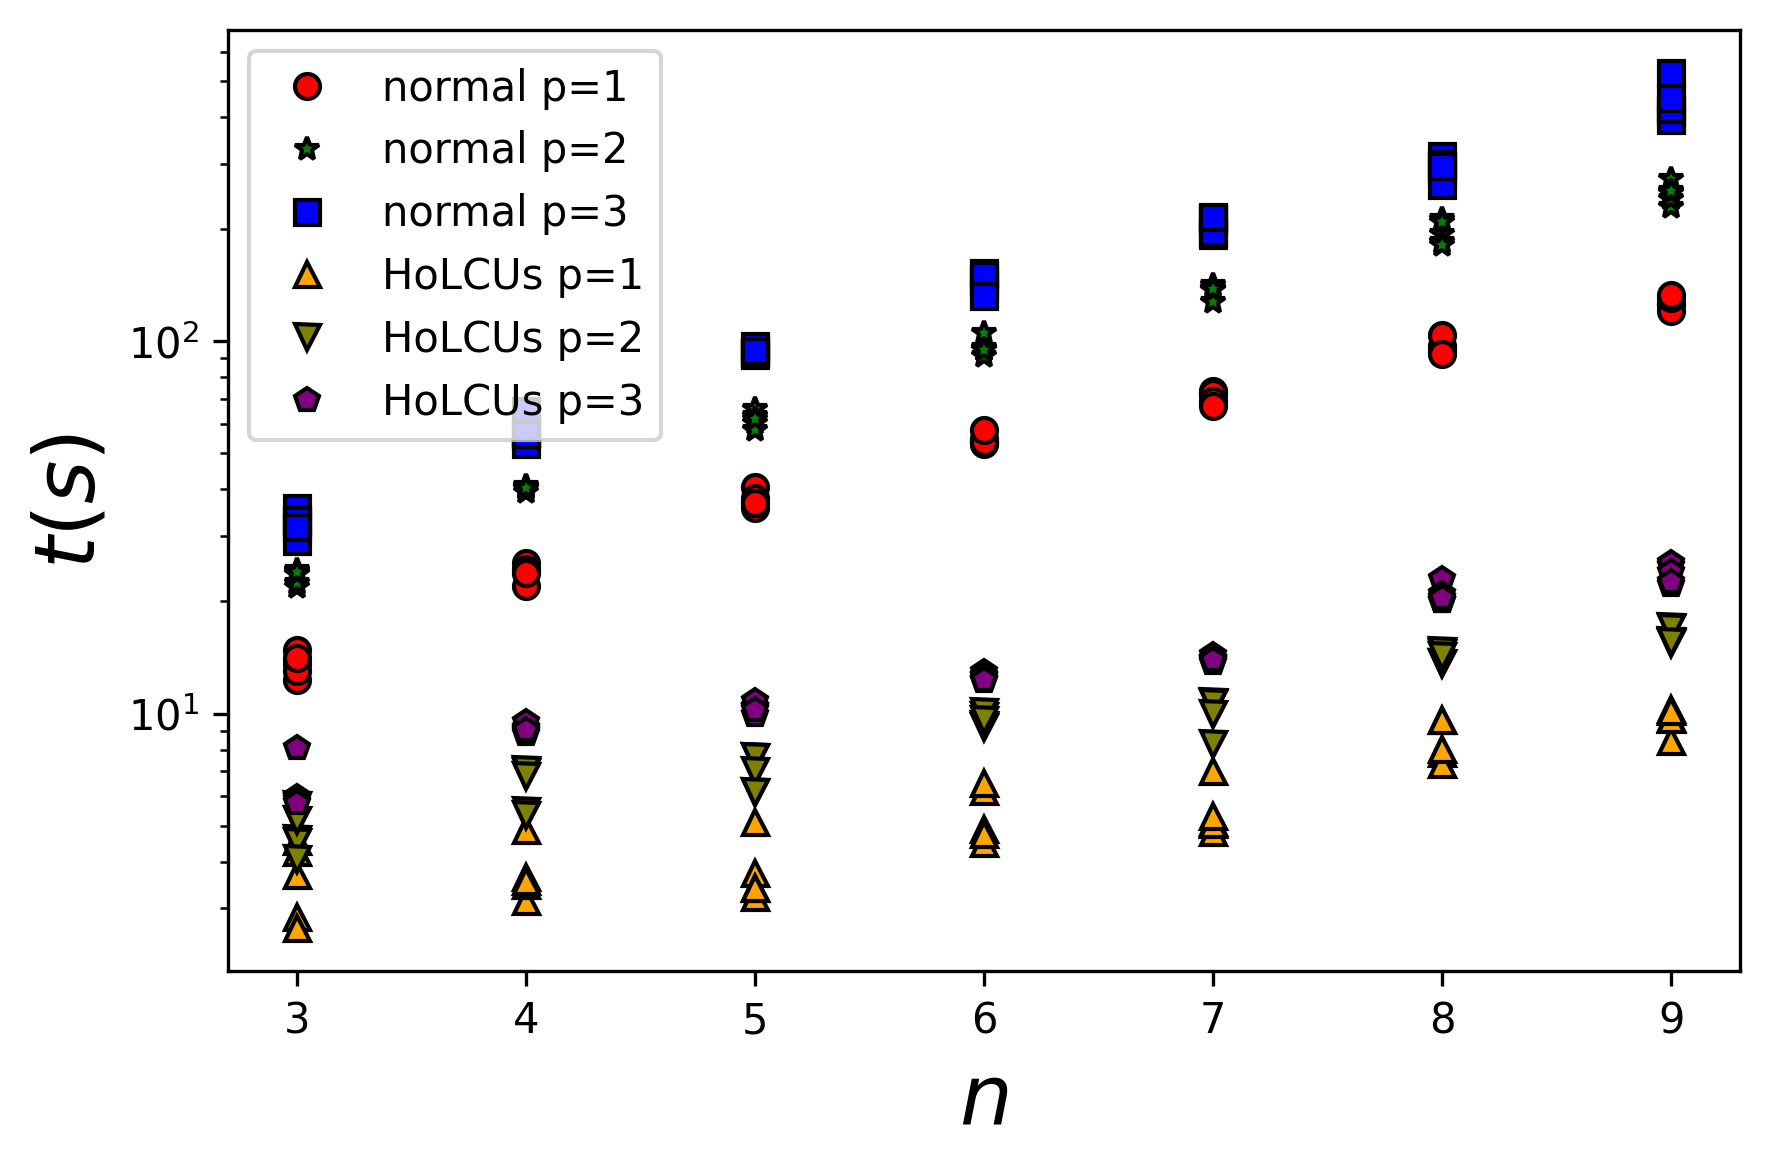

In [ ]:
data_normal1 = np.loadtxt('/content/drive/MyDrive/QAOA_HLCU/normal_layers_1')
data_normal2 = np.loadtxt('/content/drive/MyDrive/QAOA_HLCU/normal_layers_2')
data_normal3 = np.loadtxt('/content/drive/MyDrive/QAOA_HLCU/normal_layers_3')

data_HoLCUs1 = np.loadtxt('/content/drive/MyDrive/QAOA_HLCU/HoLCUs_layers_1')
data_HoLCUs2 = np.loadtxt('/content/drive/MyDrive/QAOA_HLCU/HoLCUs_layers_2')
data_HoLCUs3 = np.loadtxt('/content/drive/MyDrive/QAOA_HLCU/HoLCUs_layers_3')

# The n values
x_n = [3+_//5 for _ in range(len(data_normal1))]

plt.figure('Time_vs_n', dpi=300, figsize=(6,4))
plt.xlabel(r'$n$', fontsize=20); plt.ylabel(r'$t(s)$', fontsize=20)

plt.plot(x_n, data_normal1, 'or', mec='black', label='normal p=1')
plt.plot(x_n, data_normal2, '*g', mec='black', label='normal p=2')
plt.plot(x_n, data_normal3, 's', color = 'blue', mec='black', label='normal p=3')


plt.plot(x_n, data_HoLCUs1, '^', color='orange', mec='black', label='HoLCUs p=1')
plt.plot(x_n, data_HoLCUs2, 'v', color='olive', mec='black', label='HoLCUs p=2')
plt.plot(x_n, data_HoLCUs3, 'p', color = 'purple', mec='black', label='HoLCUs p=3')

plt.legend();plt.yscale('log')
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/QAOA_HLCU/Time_vs_n.pdf'); plt.show()


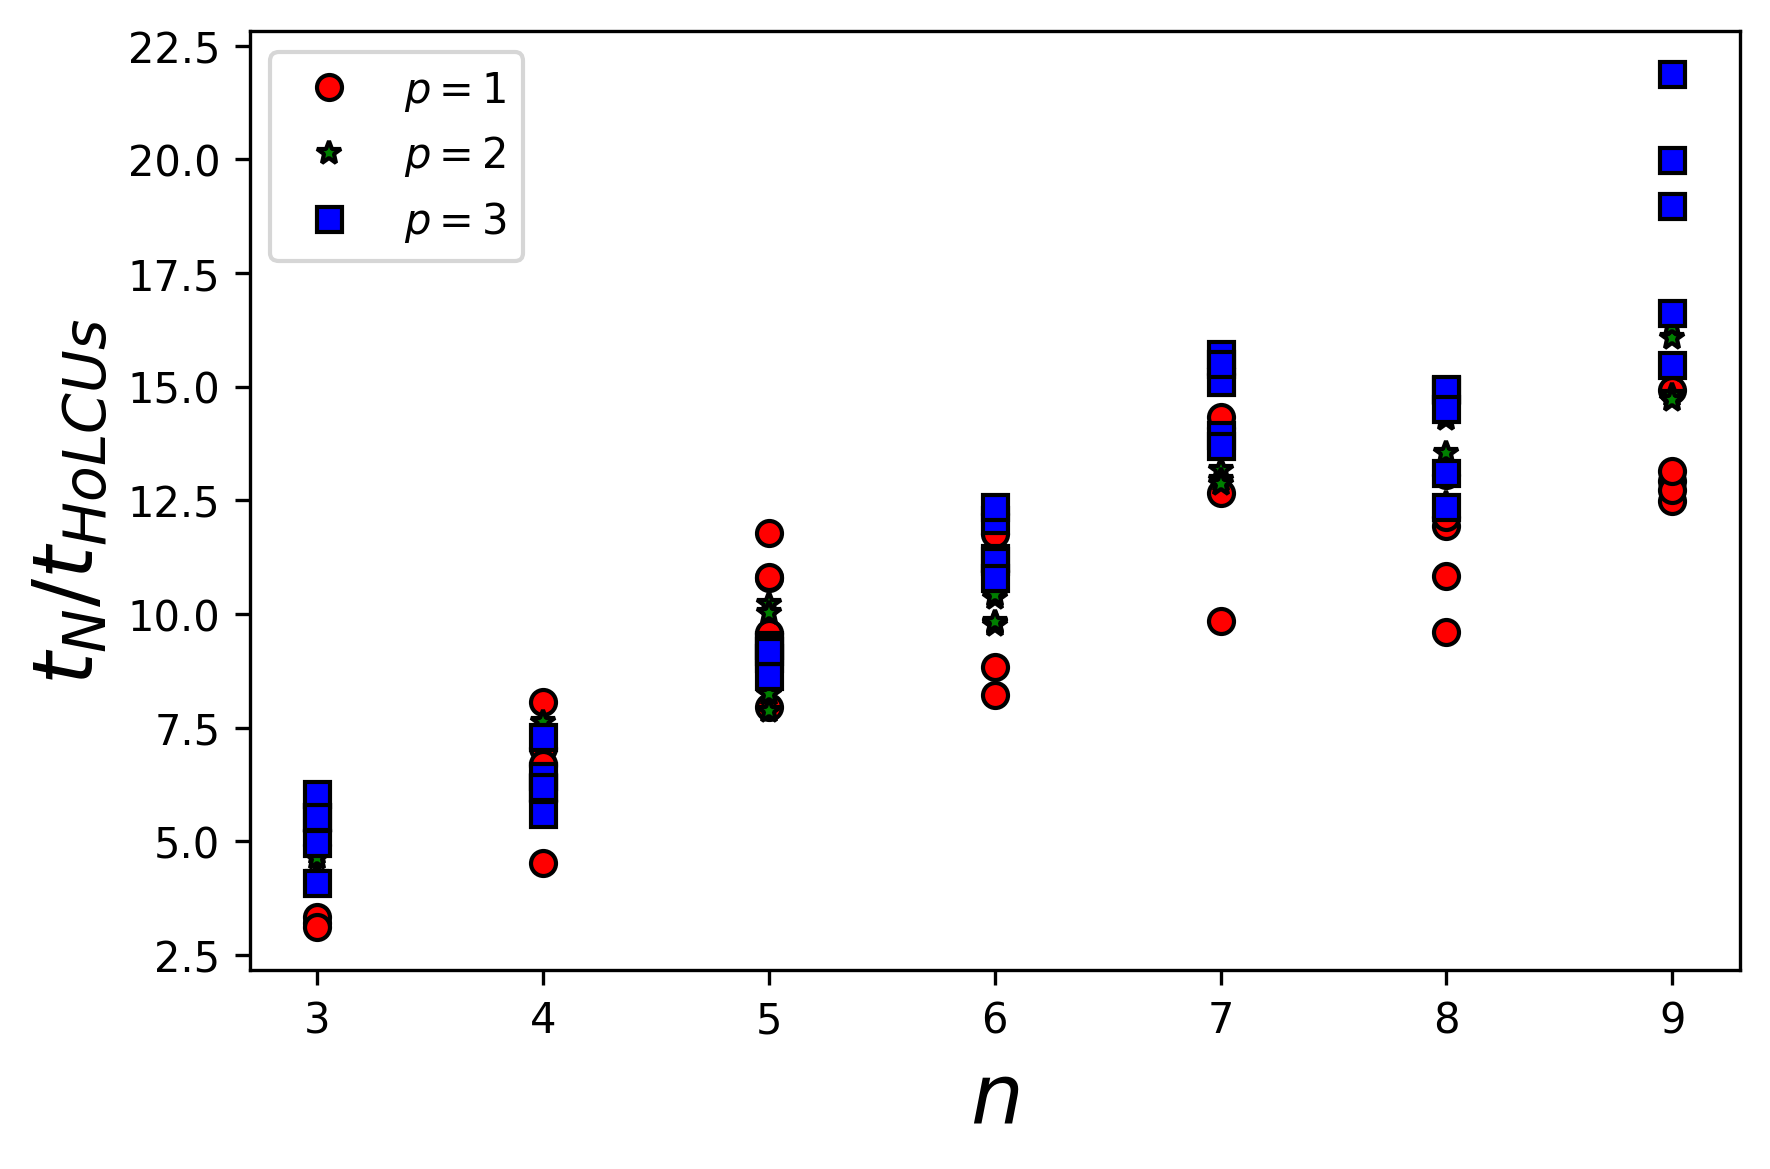

In [ ]:
data_normal1 = np.loadtxt('/content/drive/MyDrive/QAOA_HLCU/normal_layers_1')
data_normal2 = np.loadtxt('/content/drive/MyDrive/QAOA_HLCU/normal_layers_2')
data_normal3 = np.loadtxt('/content/drive/MyDrive/QAOA_HLCU/normal_layers_3')

data_HoLCUs1 = np.loadtxt('/content/drive/MyDrive/QAOA_HLCU/HoLCUs_layers_1')
data_HoLCUs2 = np.loadtxt('/content/drive/MyDrive/QAOA_HLCU/HoLCUs_layers_2')
data_HoLCUs3 = np.loadtxt('/content/drive/MyDrive/QAOA_HLCU/HoLCUs_layers_3')

# The n values
x_n = [3+_//5 for _ in range(len(data_normal1))]

plt.figure('Time_vs_n_Accel', dpi=300, figsize=(6,4))
plt.xlabel(r'$n$', fontsize=20); plt.ylabel(r'$t_N/t_{HoLCUs}$', fontsize=20)

plt.plot(x_n, data_normal1/data_HoLCUs1, 'or', mec='black', label=r'$p=1$')
plt.plot(x_n, data_normal2/data_HoLCUs2, '*g', mec='black', label=r'$p=2$')
plt.plot(x_n, data_normal3/data_HoLCUs3, 's', color = 'blue', mec='black', label=r'$p=3$')

plt.legend()#;plt.yscale('log')
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/QAOA_HLCU/Time_vs_n_Accel.pdf'); plt.show()

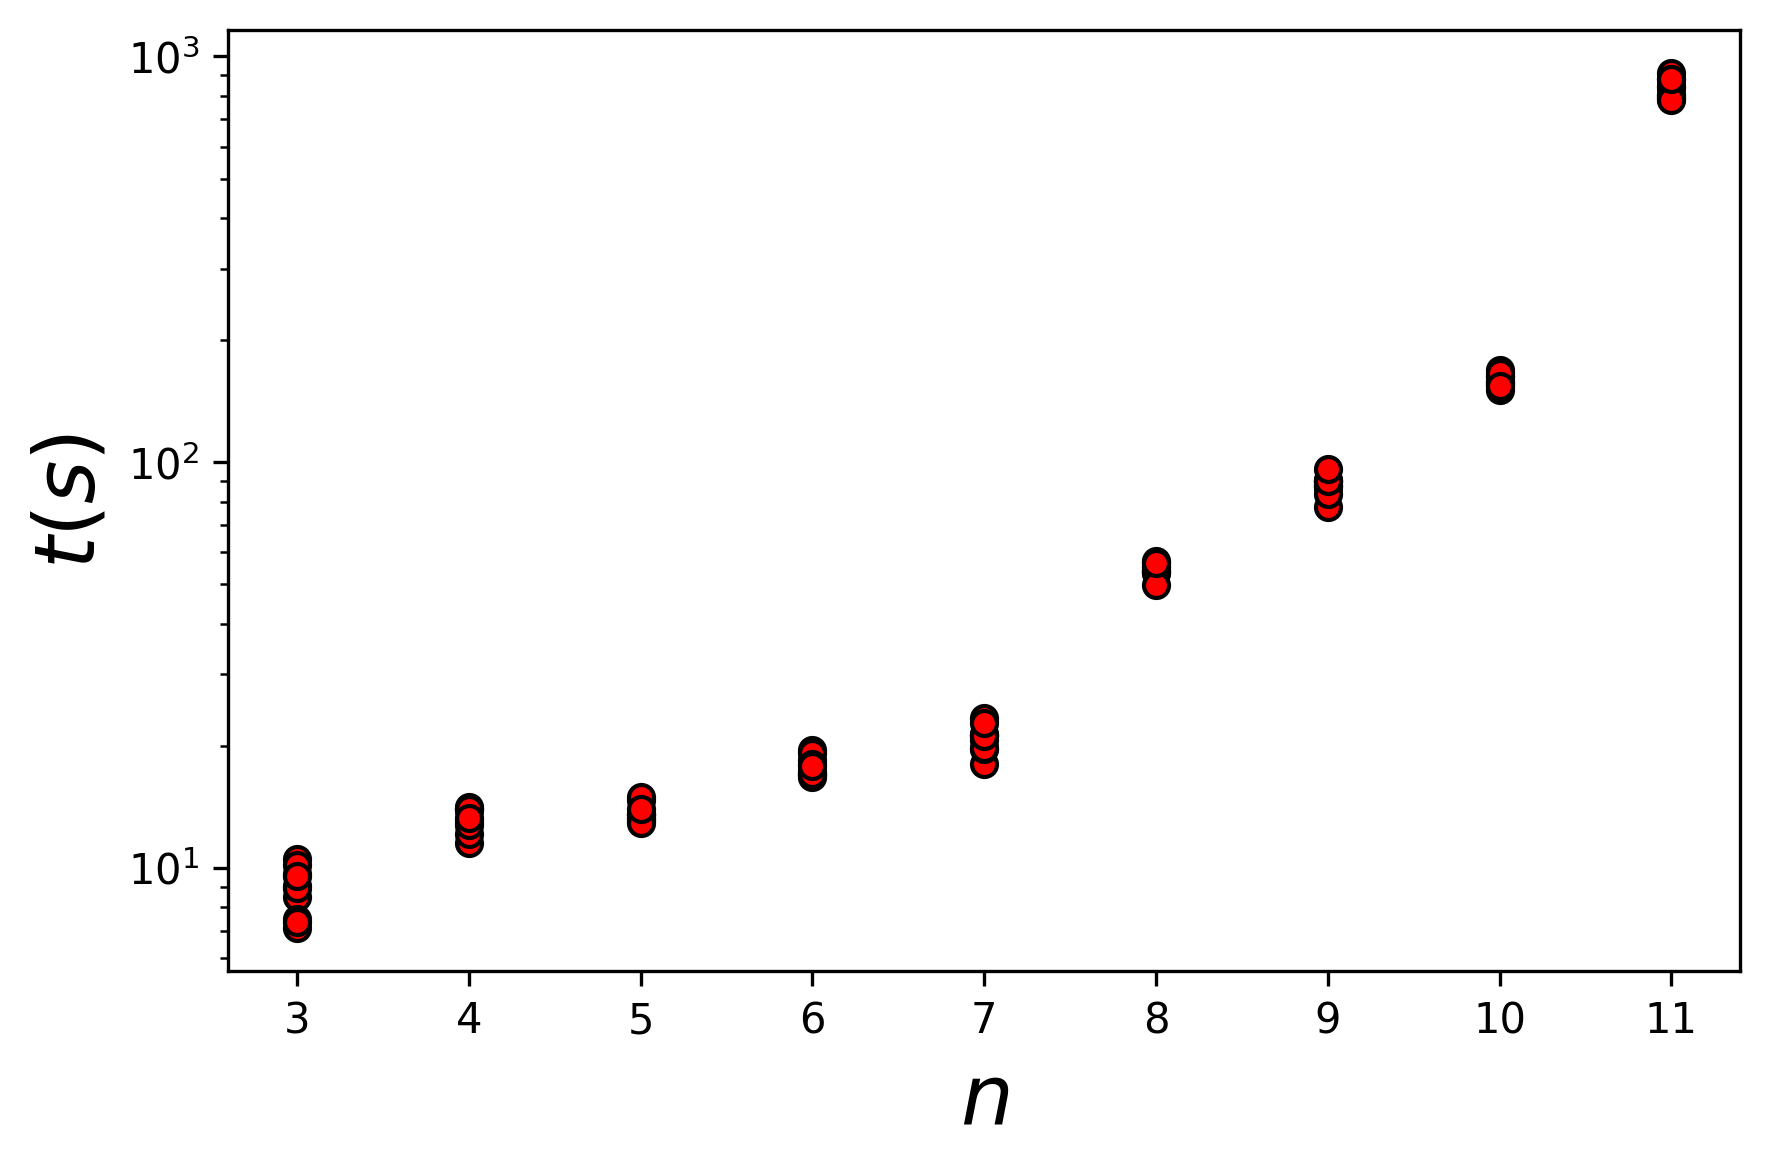

In [ ]:
data_HoLCUs = np.loadtxt('/content/drive/MyDrive/QAOA_HLCU/HoLCUs_final')

# The n values
y_n = [3+_//10 for _ in range(len(data_HoLCUs))]

plt.figure('Time_HoLCUs_vs_n', dpi=300, figsize=(6,4))
plt.xlabel(r'$n$', fontsize=20); plt.ylabel(r'$t(s)$', fontsize=20)

plt.plot(y_n, data_HoLCUs, 'or', mec='black')
plt.yscale('log')
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/QAOA_HLCU/Time_HoLCUs_vs_n.pdf'); plt.show()